In [1]:
import numpy as np
from scipy import random, stats
import networkx as nx
import pandas as pd
import random
import collections
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib as mplt
import os
%matplotlib inline

plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 1.2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2

from matplotlib.colors import ListedColormap
from matplotlib import gridspec
import palettable as pltt
import matplotlib.font_manager as fm


# set the font family style
mplt.rcParams['font.family'] = 'Avenir'
mplt.rcParams['pdf.fonttype'] = 42

Simulations are externally run through bash and python scripts.

Here's the bash code that I used to run the simulations

Here's the python code named `SimHomMix_kuniformHG_PARAMETERS_size_p_I.py` called by the bash script.

The first thing I have to do is to read and aggregate the different runs

In [ ]:
ps = [0.01, 0.03, 0.05]
group_sizes = np.arange(21,41) 
betas = np.linspace(0,1,60)

rule = 'intersection'
n_runs = 50
N = 1000
t_max = 1e6

for p in ps:
    for group_size in group_sizes:
        print(p, group_size)
        
        for run_id in range(n_runs):

            indir = '../Results/Simulations/HONG_2words_HomMix_kHG/group_size_%i/%s/fixed_p%.2f_varbeta_run%i/'%(group_size, rule, p, run_id)

            last_k_values = 100 #for average
            #Preparing output file
            f = open(indir+'summary_N%i.csv'%N,'w')
            f.write('beta,avg_n_A+p,std_n_A+p,avg_n_B,std_n_B,avg_n_AB,std_n_AB\n')

            for beta in betas:
                #Reading file
                df = pd.read_csv(indir+'HONG_densities_N%i_beta%.4f_p%.4f.csv'%(N, beta, p))

                #Checking if simulation reached an absorbing state
                if (df.tail(1)['time'].values[0]==t_max)or(df.tail(1)['n_A+p'].values[0]==0)or(df.tail(1)['n_A+p'].values[0]==1): #Yes
                    n_Ap = df.tail(1)['n_A+p'].values[0]
                    n_B = df.tail(1)['n_B'].values[0]
                    n_AB = df.tail(1)['n_AB'].values[0]
                    line = str(beta)+','+str(n_Ap)+','+'0'+','+str(n_B)+','+'0'+','+str(n_AB)+','+'0'+'\n'
                    f.write(line)
                else: #Getting stationary values
                    avgdf = df.tail(last_k_values).mean()
                    stddf = df.tail(last_k_values).std()

                    avg_n_Ap = avgdf['n_A+p'].values[0]
                    avg_n_B = avgdf['n_B'].values[0]
                    avg_n_AB = avgdf['n_AB'].values[0]
                    std_n_Ap = stdgdf['n_A+p'].values[0]
                    std_n_B = stddf['n_B'].values[0]
                    std_n_AB = stddf['n_AB'].values[0]

                    line = str(beta)+','+str(avg_n_Ap)+','+str(std_n_Ap)+','+str(n_B)+','+str(std_n_B)+','+str(n_AB)+','+str(std_n_AB)+'\n'
                    f.write(line)

            f.close()

0.01 21
0.01 22


# Plotting

In [5]:
def get_Delta_beta_from_single_run(df):
    """
    Given a dataframe with columns beta, avg_n_A+p
    it returns the range of beta for which avg_n_A+p is 1
    """
    dfx = df[(df['avg_n_A+p'].astype(int)==1)]
    Delta_beta = dfx['beta'].max()-dfx['beta'].min()
    
    if np.isnan(Delta_beta): Delta_beta = 0
        
    return Delta_beta

def get_Delta_beta_limits(df):
    """
    Given a dataframe with columns beta, avg_n_A+p
    it returns the min and max beta of the range of beta for which avg_n_A+p is 1
    """
    dfx = df[(df['avg_n_A+p'].astype(int)==1)]
    beta_min = dfx['beta'].min()
    beta_max = dfx['beta'].max()        
    return beta_min, beta_max

def get_Delta_beta_from_multiple_runs(group_size, rule, p, n_runs, N):
    
    Delta_betas = []
    for run_id in range(n_runs):
        indir = '../Results/Simulations/HONG_2words_HomMix_kHG/group_size_%i/%s/fixed_p%.2f_varbeta_run%i/'%(group_size, rule, p, run_id)
        df = pd.read_csv(indir+'summary_N%i.csv'%N)
        Delta_beta = get_Delta_beta_from_single_run(df)
        Delta_betas.append(Delta_beta)
        
    Delta_betas = np.array(Delta_betas)    
    median_Delta_beta = np.median(Delta_betas)
    std_Delta_beta = np.std(Delta_betas)
        
    return median_Delta_beta, std_Delta_beta

def get_nAB_from_multiple_runs_given_beta(beta, group_size, rule, p, n_runs, N):
    
    n_ABs = []
    for run_id in range(n_runs):
        indir = '../Results/Simulations/HONG_2words_HomMix_kHG/group_size_%i/%s/fixed_p%.2f_varbeta_run%i/'%(group_size, rule, p, run_id)
        df = pd.read_csv(indir+'summary_N%i.csv'%N)
        n_AB = df[np.isclose(df['beta'], beta)]['avg_n_AB'].values[0]
        n_ABs.append(n_AB)
        
    n_ABs = np.array(n_ABs)    
    median_n_ABs = np.median(n_ABs)
    std_n_ABs = np.std(n_ABs)
        
    return median_n_ABs, std_n_ABs

Preparing the Delta_beta in advance

In [6]:
group_sizes = np.arange(2,41)
ps = [0.01, 0.03, 0.05]#, 0.08]
N = 1000
rule = 'intersection'
n_runs = 50

median_Delta_betas_given_p = {}
std_Delta_betas_given_p = {}

for i, p in enumerate(ps):
    median_Delta_betas, std_Delta_betas = [], []
    for group_size in group_sizes:
        median_Delta_beta, std_Delta_beta = get_Delta_beta_from_multiple_runs(group_size, rule, p, n_runs, N)
        median_Delta_betas.append(median_Delta_beta)
        std_Delta_betas.append(std_Delta_beta)
    median_Delta_betas_given_p[p] = np.array(median_Delta_betas)
    std_Delta_betas_given_p[p] = np.array(std_Delta_betas)

Preparing also the n_AB(group_size), given beta and p

In [7]:
group_sizes = np.arange(2,41)
ps = [0.01, 0.03, 0.05]#, 0.08]
N = 1000
rule = 'intersection'
n_runs = 50
beta = 0.711864

median_n_ABs_given_p = {}
std_n_ABs_given_p = {}

for i, p in enumerate(ps):
    median_nABs, std_nABs = [], []
    for group_size in group_sizes:
        median_nAB, std_nAB = get_nAB_from_multiple_runs_given_beta(beta, group_size, rule, p, n_runs, N)
        median_nABs.append(median_nAB)
        std_nABs.append(std_nAB)
    median_n_ABs_given_p[p] = np.array(median_nABs)
    std_n_ABs_given_p[p] = np.array(std_nABs)

Plotting

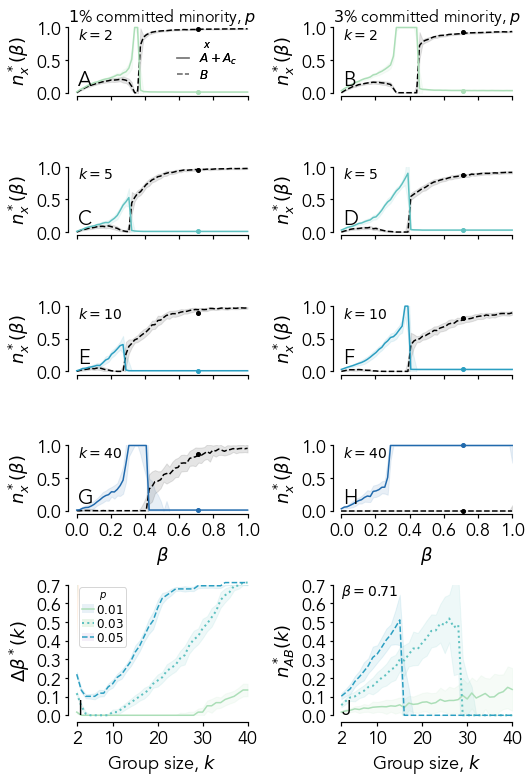

In [8]:
rule = 'intersection'
selected_ps = [0.01, 0.03]
ps = [0.01, 0.03, 0.05]#, 0.08]
selected_group_sizes = [2,5,10,40]
n_runs = 50
N = 1000

fig = plt.figure(figsize=(7.5,11))

gs = gridspec.GridSpec(nrows=5, ncols=2, height_ratios=[0.6,0.6,0.6,0.6,1.2], width_ratios=[1,1]) 
axes = [plt.subplot(g) for g in gs]

rangec = np.linspace(0.3,1,6)
colors = [plt.cm.YlGnBu(i) for i in rangec]
axlabels = ['A','B','C','D','E','F','G','H']

###########################################################################
axindex = 0
for ii, group_size in enumerate(selected_group_sizes):
    for jj, p in enumerate(selected_ps):
            
        tensor = []
        for run_id in range(n_runs):
            fname = '../Results/Simulations/HONG_2words_HomMix_kHG/group_size_%i/%s/fixed_p%.2f_varbeta_run%i/summary_N%i.csv'%(group_size,rule,p,run_id,N)
            df = pd.read_csv(fname)
            tensor.append(df.to_numpy())
        #Taking the average from simulations and plotting it
        tensor = np.array(tensor)
        med_tensor = np.median(tensor, axis=0)
        std_tensor = np.std(tensor, axis=0)
        med_df = pd.DataFrame(med_tensor, index=None,
                                columns=['beta','avg_n_A+p','std_n_A+p','avg_n_B','std_n_B','avg_n_AB','std_n_AB'])
        std_df = pd.DataFrame(std_tensor, index=None,
                              columns=['beta','avg_n_A+p','std_n_A+p','avg_n_B','std_n_B','avg_n_AB','std_n_AB'])
        axes[axindex].plot(med_df['beta'], med_df['avg_n_A+p'], '-', color=colors[ii], mec=colors[ii], zorder=3, mew=1.2, clip_on=False)
        axes[axindex].plot(med_df['beta'], med_df['avg_n_B'], '--', ms=8, color='black', mec='black', zorder=2, mew=1.2, clip_on=False)
        axes[axindex].fill_between(med_df['beta'], med_df['avg_n_A+p']-std_df['avg_n_A+p'], med_df['avg_n_A+p']+std_df['avg_n_A+p'], color=colors[ii], alpha=0.1, zorder=1)
        axes[axindex].fill_between(med_df['beta'], med_df['avg_n_B']-std_df['avg_n_B'], med_df['avg_n_B']+std_df['avg_n_B'], color='black', alpha=0.1, zorder=1)
        
        #Adding the points at beta=0.711864
        dfx = df[np.isclose(med_df['beta'], 0.711864)]
        axes[axindex].plot(dfx['beta'], dfx['avg_n_A+p'], 'o', ms=4, color=colors[ii], clip_on=False)
        axes[axindex].plot(dfx['beta'], dfx['avg_n_B'], 'o', ms=4, color='black', clip_on=False)
        
        axes[axindex].set_xlim(0,1)
        axes[axindex].set_xticks([0,0.2,0.4,0.6,0.8,1])
        if axindex in [6, 7]:
            axes[axindex].set_xlabel(r'$\beta$', size=18)
        else:
            axes[axindex].set_xticklabels([])
            axes[axindex].set_xlabel(None)
        axes[axindex].set_ylabel(r'$n_x^*(\beta)$', size=18)
        axes[axindex].set_ylim(0,1)
        axes[axindex].set_yticks([0,0.5,1])
        axes[axindex].tick_params(axis='both', which='major', labelsize=18)
        
        if ii==0:
            axes[axindex].set_title(r'$%i$'%(int(p*100))+'% committed minority, $p$', size=16)  
        
        axes[axindex].annotate(r'$k=%i$'%(group_size), xy=(0.01, 0.82), xycoords="axes fraction", fontsize=14)
        axes[axindex].annotate(axlabels[axindex], xy=(0.01, 0.12), xycoords="axes fraction", fontsize=20, fontweight="bold")
        
        ############## Background color for Deltabeta ##############
        
        #xmin, xmax = get_Delta_beta_limits(med_df)
        #axes[axindex].axvspan(xmin, xmax, facecolor='lightgray', alpha=0.3, zorder=0)
        
        ########### LEGEND ###########
        if axindex==0:
            handles = [Line2D([0], [0], linestyle='-', color='gray', mew=1.2),
            Line2D([0], [0], linestyle='--', color='gray', mew=1.2)]
            labels = [r'$A+A_c$', r'$B$']
            lg2 = axes[axindex].legend(handles, labels, loc='center right', title='$x$', labelspacing=0.1,
                                       fontsize='large', frameon=False, handlelength=1)
            axes[axindex].add_artist(lg2)
        
        axindex +=1

#axes[axindex].annotate(axlabels[axindex], xy=(0., 0.01), xycoords="axes fraction", fontsize=20, fontweight="bold")


###########################################################################   
###########################################################################   
marker = ''
ms = 4
lss = ['-',':','--']
lws = [1.5,2,1.5]

#Here I'll store the plots for the legend
pxs = []

for i, p in enumerate(ps):
    median_Delta_betas = median_Delta_betas_given_p[p]
    std_Delta_betas = std_Delta_betas_given_p[p]    
    px = axes[axindex].plot(group_sizes, median_Delta_betas, ls=lss[i], lw=lws[i], marker=marker, mfc=colors[i], ms=ms,
                 color=colors[i], mec=colors[i], zorder = 1, mew=1, clip_on=False)
    pxs.append(px[0])
    axes[axindex].fill_between(group_sizes, median_Delta_betas-std_Delta_betas, median_Delta_betas+std_Delta_betas, color=colors[i], alpha=0.1, zorder=0)

axes[axindex].set_xlabel(r'Group size, $k$', size=18)
axes[axindex].set_ylabel(r'$\Delta\beta^*(k)$', size=18)
axes[axindex].tick_params(axis='both', which='major', labelsize=18)
axes[axindex].set_ylim(0,0.7)
axes[axindex].set_xlim(2,40)
axes[axindex].set_xticks([2,10,20,30,40])
axes[axindex].set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
    
#################################### LEGEND ####################################

#Creating fillings for legend entries
pxsf = [axes[axindex].fill(np.NaN, np.NaN, color, alpha=0.1)[0] for color in colors]

axes[axindex].legend([(pxsf[ii], pxs[ii]) for ii in range(len(ps))],
          [r'$%.2f$'%p for p in ps], fontsize=12, handlelength=1, title=r'$p$',
          columnspacing=0.1, labelspacing=0.1, borderaxespad=0.2, handletextpad=0.2,
          borderpad=0.2, frameon=True, loc='upper left', ncol=1)

axes[axindex].annotate('I', xy=(0., 0.01), xycoords="axes fraction", fontsize=20, fontweight="bold")

axindex+=1
########################################################################

for i, p in enumerate(ps):
    median_n_ABs = median_n_ABs_given_p[p]
    std_n_ABs = std_n_ABs_given_p[p]    
    px = axes[axindex].plot(group_sizes, median_n_ABs, ls=lss[i], lw=lws[i], marker=marker, mfc=colors[i], ms=ms,
                 color=colors[i], mec=colors[i], zorder = 1, mew=1.2, clip_on=False)
    axes[axindex].fill_between(group_sizes, median_n_ABs-std_n_ABs, median_n_ABs+std_n_ABs, color=colors[i], alpha=0.1, zorder=0)

axes[axindex].set_xlabel(r'Group size, $k$', size=18)
axes[axindex].set_ylabel(r'$n^*_{AB}(k)$', size=18)
axes[axindex].tick_params(axis='both', which='major', labelsize=18)
axes[axindex].set_ylim(0,0.7)
axes[axindex].set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
axes[axindex].set_xlim(2,40)
axes[axindex].set_xticks([2,10,20,30,40])
#ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])

axes[axindex].annotate(r'$\beta=0.71$', xy=(0., 0.92), xycoords="axes fraction", fontsize=14)
axes[axindex].annotate('J', xy=(0., 0.01), xycoords="axes fraction", fontsize=20, fontweight="bold")


###########################################################################
for ax in axes:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('axes', -0.05))
###########################################################################   


fig.tight_layout()

filename = "../Figures/NG_group_size_effects.pdf"
plt.savefig(filename, bbox_inches='tight', dpi=150)